# Preprocesss raw audio files

This notebook contains code to perform the following preprocessing steps on raw audio files:

1. Volume normalization 
2. Using deepfilternet for noise removal: https://github.com/Rikorose/DeepFilterNet
3. Resampling of frequencies to 16 kHz since the high frequencies in the audio recordings typically do not contain speech
5. Trim beginning and end silence 
6. Using spakder diarization for removal interviewer speech: https://huggingface.co/pyannote/speaker-diarization-3.1. Requires access to pyannote/segmentation-3.0 model as well.

To use these models, need to login into huggingface and request gated acccess in your account. 

In [ ]:
from huggingface_hub import notebook_login
notebook_login() 

## Setup

In [ ]:
# !pip install torch torchaudio -f https://download.pytorch.org/whl/cpu/torch_stable.html
# !pip install deepfilternet
# !pip install pyannote.audio

In [12]:
import opensmile
import audiofile
from tqdm import tqdm
import librosa
import pandas as pd  
import numpy as np
import os 
import soundfile as sf
import torch

In [ ]:
from df.enhance import enhance, init_df, load_audio, save_audio
from df.utils import download_file
from pyannote.audio.pipelines import SpeakerDiarization
from pyannote.core import Segment, Annotation

## Functions

In [5]:
def compute_total_pause_time(y, sr, silence_threshold=0.02, frame_length=2048, hop_length=512):
    """
    Compute the total pause time (silent regions) in an audio file.
    
    Parameters:
        audio_path (str): Path to the audio file.
        silence_threshold (float): Energy threshold below which the region is considered a pause (silence).
        frame_length (int): Length of each frame to analyze in samples.
        hop_length (int): The number of samples to shift for each frame.
    
    Returns:
        float: Total pause time in seconds.
    """
    # Compute the energy (Root Mean Square) of the audio signal
    energy = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]
    
    # Identify silent regions where energy is below the threshold
    silence = energy < silence_threshold
    
    # Get the time intervals of the silence
    times = librosa.frames_to_time(np.arange(len(energy)), sr=sr, hop_length=hop_length)
    
    # Calculate the total pause time
    pause_time = 0.0
    start = None
    for i in range(len(silence)):
        if silence[i] and start is None:
            # Start of a silent region
            start = times[i]
        elif not silence[i] and start is not None:
            # End of a silent region
            end = times[i]
            pause_time += (end - start)
            start = None
    
    # If the audio ends in silence, add the final pause duration
    if start is not None:
        pause_time += (times[-1] - start)
    
    total_signal_time = librosa.get_duration(y=y, sr=sr)
    
    # Compute the ratio of pause time to signal time
    ratio = pause_time / total_signal_time
    
    return ratio


In [6]:

def strip_silence(y, sr, silence_threshold=0.02, frame_length=2048, hop_length=512, output_path=None):
    """
    Strip silence from an audio file and save the resulting audio without silence.
    
    Parameters:
        audio_path (str): Path to the input audio file.
        silence_threshold (float): Energy threshold below which the region is considered silent.
        frame_length (int): Length of each frame to analyze in samples.
        hop_length (int): The number of samples to shift for each frame.
        output_path (str, optional): Path to save the output audio without silence. If None, it will return the numpy array.
    
    Returns:
        numpy.ndarray: Audio signal with silence removed (if no output_path is provided).
    """
    # Compute the energy (Root Mean Square) of the audio signal
    energy = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]
    
    # Identify non-silent regions where energy is above the threshold
    non_silent_frames = energy > silence_threshold
    
    # Get the time intervals corresponding to non-silent frames
    times = librosa.frames_to_time(np.arange(len(energy)), sr=sr, hop_length=hop_length)
    
    # Extract the non-silent portions of the audio
    non_silent_audio = []
    start_idx = None
    
    for i in range(len(non_silent_frames)):
        if non_silent_frames[i] and start_idx is None:
            # Start of non-silent region
            start_idx = librosa.frames_to_samples(i, hop_length=hop_length)
        elif not non_silent_frames[i] and start_idx is not None:
            # End of non-silent region
            end_idx = librosa.frames_to_samples(i, hop_length=hop_length)
            non_silent_audio.append(y[start_idx:end_idx])
            start_idx = None
    
    # Handle case where the audio ends with a non-silent region
    if start_idx is not None:
        non_silent_audio.append(y[start_idx:])
    
    # Concatenate all non-silent audio parts
    stripped_audio = np.concatenate(non_silent_audio)
    
    # Save the result or return it
    return stripped_audio

## Load data

In [ ]:
# load raw data
train_y = pd.read_csv("original/train_labels.csv", index_col=0)
ss = pd.read_csv("original/submission_format.csv", index_col=0)

## Preprocessing

In [ ]:
INPUT_FOLDER = "raw"
EXPORT_FOLDER = "raw_preprocessed"
TARGET_SR = 16000   # target sampling rate 
ORIGINAL_SR = 48000 # original sampling rate 

In [10]:
# load default deepfilternet model
model, df_state, _ = init_df()

2024-12-18 12:36:27 | INFO     | DF | Running on torch 2.5.1
2024-12-18 12:36:27 | INFO     | DF | Running on host lingchaos-mbp.lan
2024-12-18 12:36:27 | INFO     | DF | Git commit: 8c868ba70e, branch: stable
2024-12-18 12:36:27 | INFO     | DF | Loading model settings of DeepFilterNet3
2024-12-18 12:36:27 | INFO     | DF | Using DeepFilterNet3 model at /Users/lingchm/Library/Caches/DeepFilterNet/DeepFilterNet3
2024-12-18 12:36:27 | INFO     | DF | Initializing model `deepfilternet3`
2024-12-18 12:36:27 | INFO     | DF | Found checkpoint /Users/lingchm/Library/Caches/DeepFilterNet/DeepFilterNet3/checkpoints/model_120.ckpt.best with epoch 120
2024-12-18 12:36:27 | INFO     | DF | Running on device cpu
2024-12-18 12:36:27 | INFO     | DF | Model loaded


/opt/homebrew/Caskroom/miniconda/base/envs/research/lib/python3.12/site-packages/df/checkpoint.py:77: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  latest = torch.load(lates

In [ ]:
# takes about 30 minutes to processs all audio files 
for root, dirs, files in os.walk(INPUT_FOLDER):
    for filename in files:
         
        if ".mp3" not in filename:
            continue 
    
        if "train_audios_sample" in root:
            continue 
        
        input_path_file = os.path.join(root, filename)
        export_path_file = input_path_file.replace(INPUT_FOLDER, EXPORT_FOLDER).replace(".mp3", ".wav")
        
        # load data
        audio, _ = load_audio(input_path_file, sr=ORIGINAL_SR, format="mp3")

        # normalization 
        audio = audio / torch.max(torch.abs(audio))

        # noise removal 
        enhanced_audio = enhance(model, df_state, audio)

        # resampling 
        audio_resampled = librosa.resample(np.asarray(enhanced_audio).flatten(), target_sr=TARGET_SR, orig_sr=ORIGINAL_SR)

        # trim beginning and end silence
        audio_trimmed, _ = librosa.effects.trim(audio_resampled)

        sf.write(export_path_file, audio_trimmed, TARGET_SR)
        
        print(f"Processed {input_path_file} into {export_path_file}")

## Diarization

In [292]:
INPUT_FOLDER = "raw_preprocessed"
EXPORT_FOLDER = "raw_preprocessed_diarized"
TARGET_SR = 16000
ORIGINAL_SR = 48000
MIN_SPEAKERS, MAX_SPEAKERS = 1, 2 

In [293]:
# Initialize the diarization pipeline
pipeline = SpeakerDiarization.from_pretrained("pyannote/speaker-diarization-3.1", use_auth_token=True)

In [ ]:
# takes about 700 minutes to process all files 

df_duration = pd.DataFrame(columns=["speaker_duration", "pause_duration", "pause_ratio", "removed_ratio", "original_duration"])

for root, dirs, files in os.walk(INPUT_FOLDER):
    for filename in files:
         
        if "train_audios_sample" in root:
            continue 
        
        uid = filename.replace(".wav", "")
        input_path_file = os.path.join(root, filename)
        export_path_file = input_path_file.replace(INPUT_FOLDER, EXPORT_FOLDER)
        duration_data = {}
        if os.path.exists(export_path_file):
            continue 
        # load data
        audio, sr = librosa.load(input_path_file, sr=None)
        
        # diarization 
        diarization = pipeline(input_path_file, min_speakers=MIN_SPEAKERS, max_speakers=MAX_SPEAKERS)

        # Identify the main speaker 
        speakers = diarization.labels()
        
        if len(speakers) == 0:
            continue 
        
        multiple_speakers = len(speakers) > 1 
        if multiple_speakers:
            max_duration, main_speaker = 0, speakers[0]
            speaker_duration = {}
            for speaker in speakers:
                speaker_duration[speaker] = diarization.label_duration(speaker)
                # main speaker has max duration 
                if speaker_duration[speaker] > max_duration: 
                    main_speaker = speaker
                    max_duration = speaker_duration[speaker]
            # print("Speakers and duration:", speaker_duration, "   Main speaker:", main_speaker)

        else:
            main_speaker = speakers[0]

        # compute pause ratio 
        speaker_timeline = diarization.label_timeline(main_speaker)
        gaps_timeline = diarization.get_timeline().gaps()
        pause_duration = gaps_timeline.duration()
        speaker_duration = speaker_timeline.duration()
        pause_ratio = pause_duration / speaker_duration
        duration_data["original_duration"] = diarization.get_timeline().duration()
        duration_data["pause_duration"] = pause_duration
        duration_data["speaker_duration"] = speaker_duration
        duration_data["pause_ratio"] = pause_ratio
        
        if not multiple_speakers:
            sf.write(export_path_file, audio, sr)
            continue 
        
        # remove other speaker's segments
        keep_timeline = speaker_timeline.union(gaps_timeline)
        speaker_audio = []
        for segment in keep_timeline:
            start_sample = int(segment.start * sr)
            end_sample = int(segment.end * sr)
            speaker_audio.append(audio[start_sample:end_sample])
        speaker_audio = np.concatenate(speaker_audio)
        removed_ratio = 1 - speaker_audio.shape[0] / audio.shape[0]
        print(f"{uid}  Original length {audio.shape[0]}, Removed length {removed_ratio * 100:.1f}%")
        duration_data["removed_ratio"] = speaker_duration
        
        df_duration.loc[uid] = duration_data
        
        sf.write(export_path_file, speaker_audio, sr)
    

jnpr  Original length 480001, Removed length 8.3%
hjiq  Original length 341872, Removed length 5.5%
fhsx  Original length 476160, Removed length 0.6%
rpou  Original length 478720, Removed length 4.0%
koel  Original length 480001, Removed length 79.2%
kflj  Original length 472321, Removed length 0.9%
vehz  Original length 460896, Removed length 2.5%
zjvs  Original length 480000, Removed length 4.9%
xgem  Original length 480001, Removed length 1.2%
gfxo  Original length 340992, Removed length 4.4%
alrq  Original length 480001, Removed length 2.4%
mvlw  Original length 480000, Removed length 1.6%
dcuv  Original length 275744, Removed length 5.4%
ghle  Original length 214016, Removed length 15.2%
fgtd  Original length 480001, Removed length 0.1%
vmec  Original length 480000, Removed length 0.2%
spph  Original length 328176, Removed length 2.4%
krpx  Original length 480001, Removed length 0.5%
oelh  Original length 462848, Removed length 32.0%
jozu  Original length 480001, Removed length 0.

In [ ]:
df_duration.to_csv("preprocessed/diariation_details.csv", index=True)

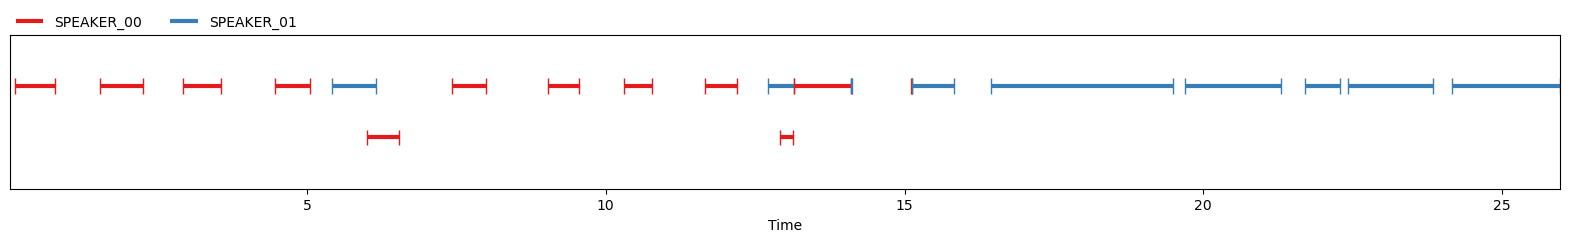

In [310]:
# test diarization
uid = "lgid"
input_path_file = os.path.join(INPUT_FOLDER, f"test_audios/{uid}.wav")
audio, sr = librosa.load(input_path_file, sr=None)
diarization = pipeline(input_path_file, min_speakers=MIN_SPEAKERS, max_speakers=MAX_SPEAKERS)
diarization

In [311]:
# Identify the main speaker 
speakers = diarization.labels()
multiple_speakers = len(speakers) > 1 
if multiple_speakers:
    max_duration, main_speaker = 0, speakers[0]
    speaker_duration = {}
    for speaker in speakers:
        speaker_duration[speaker] = diarization.label_duration(speaker)
        # main speaker has max duration 
        if speaker_duration[speaker] > max_duration: 
            main_speaker = speaker
            max_duration = speaker_duration[speaker]
    print("Speakers and duration:", speaker_duration, "   Main speaker:", main_speaker)

else:
    main_speaker = speakers[0]

# compute pause ratio 
speaker_timeline = diarization.label_timeline(main_speaker)
gaps_timeline = diarization.get_timeline().gaps()
pause_duration = gaps_timeline.duration()
speaker_duration = speaker_timeline.duration()
pause_ratio = pause_duration / speaker_duration

if multiple_speakers:
    # remove other speaker's segments
    keep_timeline = speaker_timeline.union(gaps_timeline)
    speaker_audio = []
    for segment in keep_timeline:
        start_sample = int(segment.start * sr)
        end_sample = int(segment.end * sr)
        speaker_audio.append(audio[start_sample:end_sample])
    speaker_audio = np.concatenate(speaker_audio)
    removed_ratio = 1 - speaker_audio.shape[0] / audio.shape[0]
    print(f"Original length {audio.shape[0]}, Main speaker length {speaker_audio.shape[0]} ({removed_ratio * 100:.1f}%)")


Speakers and duration: {'SPEAKER_00': 6.429375000000004, 'SPEAKER_01': 12.825}    Main speaker: SPEAKER_01
Original length 480001, Main speaker length 380956 (20.6%)
